In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import itertools
from scipy.signal import savgol_filter
import matplotlib.image as mpimg
from scipy.ndimage import gaussian_filter, laplace
from scipy import ndimage
#import cv2
from scipy import interpolate
from mpl_toolkits import mplot3d
from PIL import Image
%matplotlib inline
import IPython
import pickle
# from vtk.util import numpy_support
# import vtk
import pyvista as pv
import numpy as np
from scipy.interpolate import interpn
import plotly.graph_objects as go

#  Real time formation evaluation

23.11.2022

## 3D synthetic dataset of LWD Resistivity

## Initial JPG with 2D LWD Resistivity Profile
- | -
- | - 
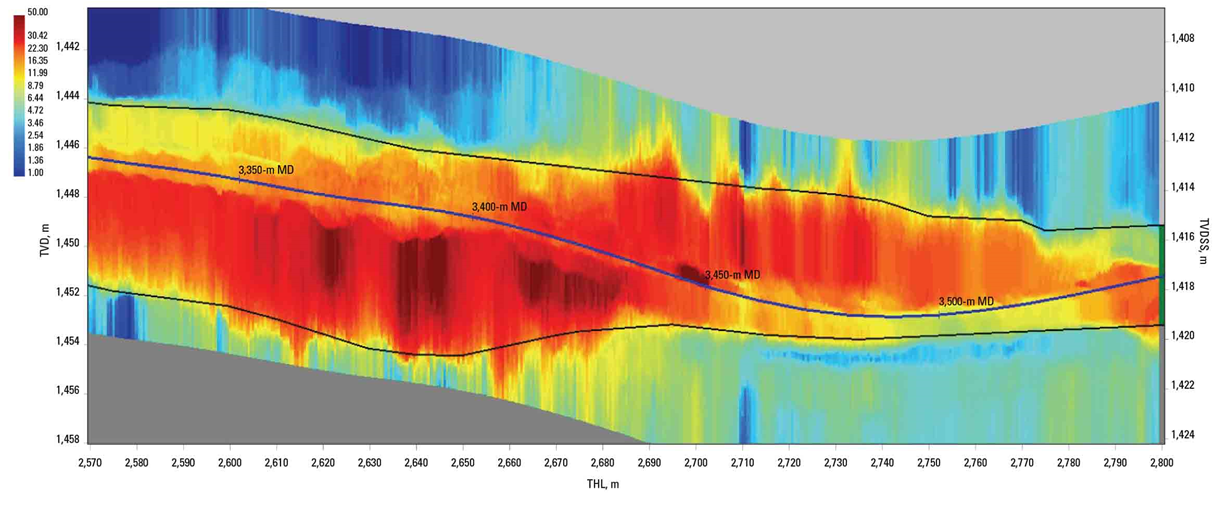 | 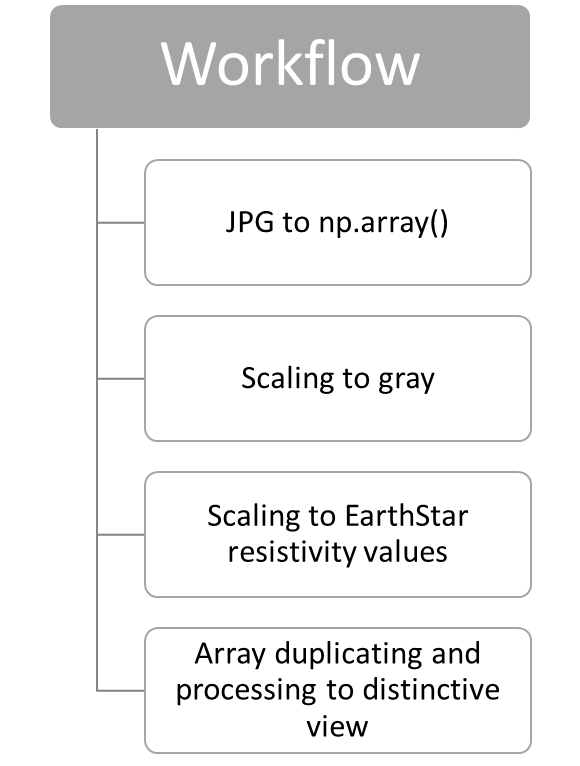


## From Multi 2d to 3D dataset


<div>
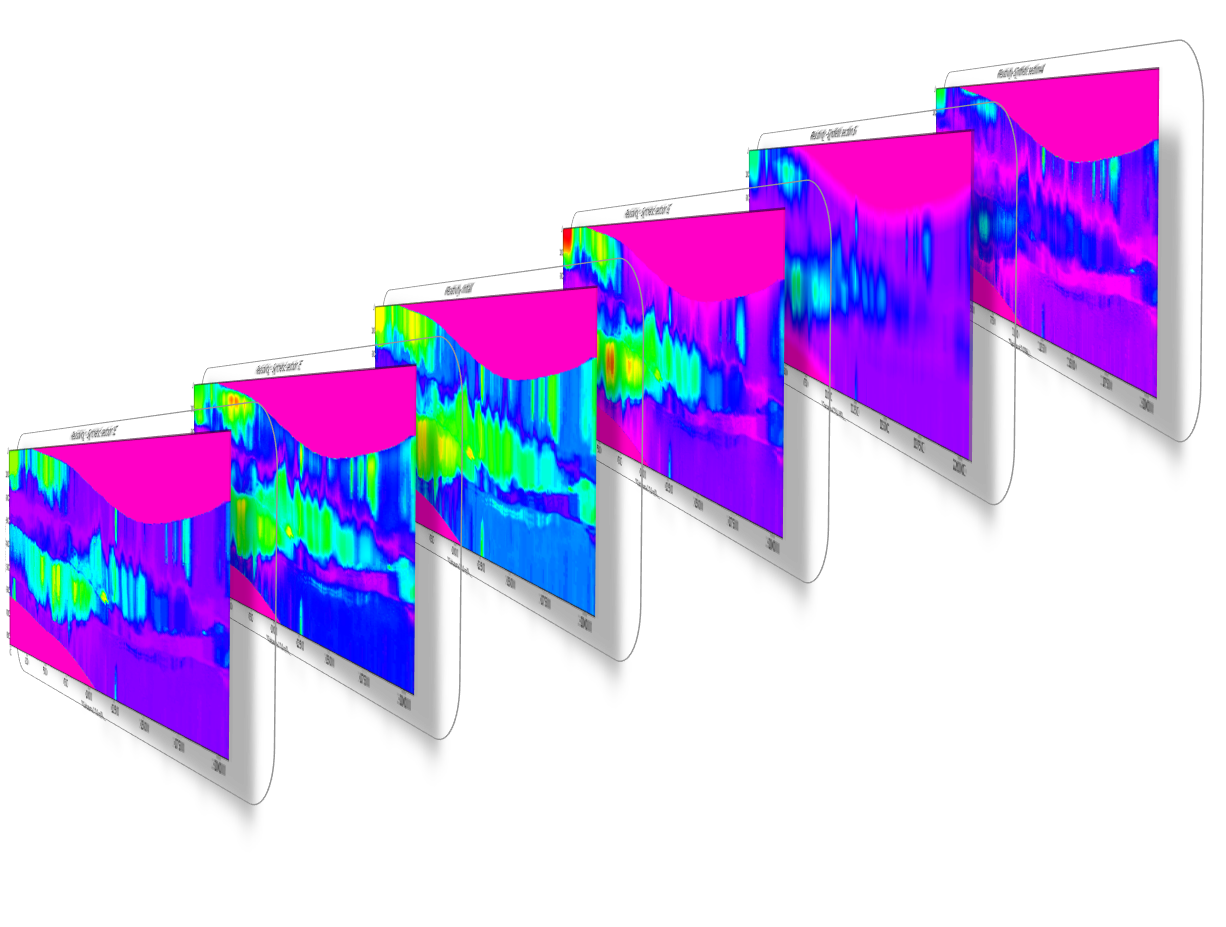
</div>


<div>
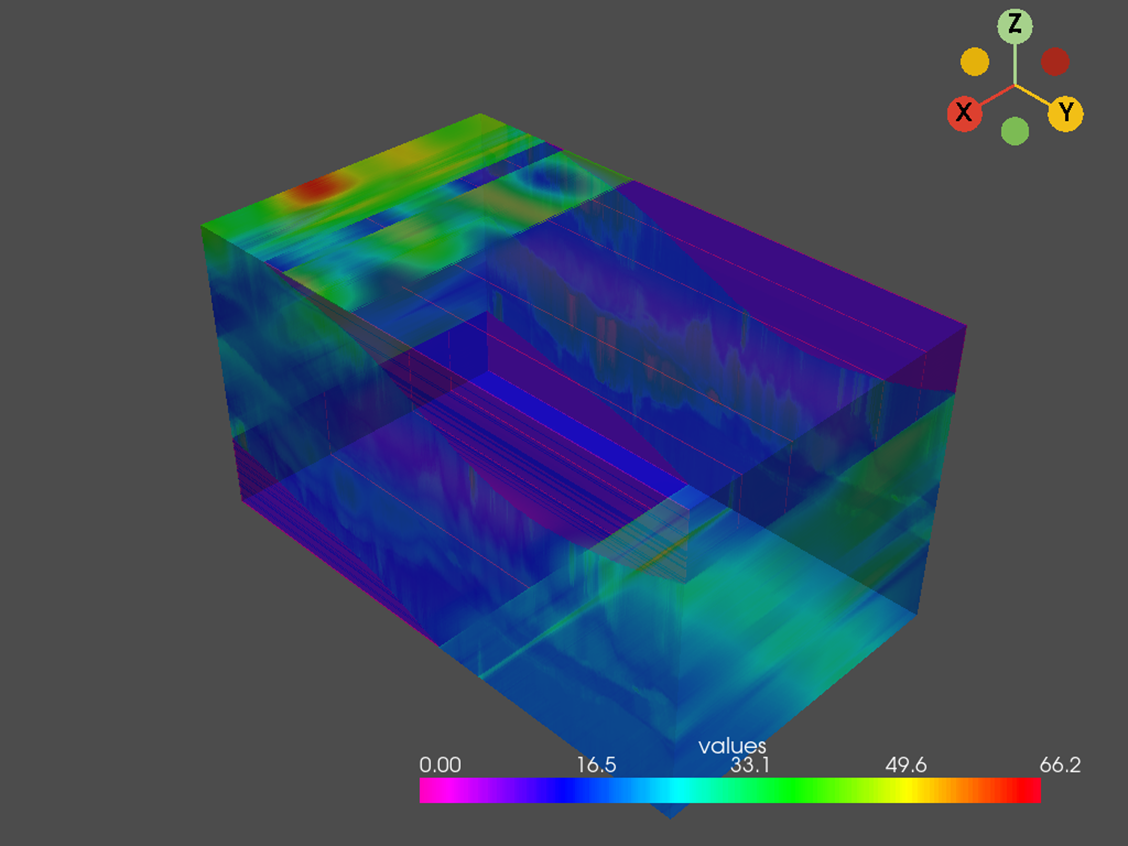
</div>

# 3D real-time geosteering based on greedy algorithm

###  <center> Objective function  </center>
$$ \large g_f(N(x_i)) = \frac{\sum_{i=0}^{n}  \int_{x_i}^{x_{i+n_s}} f(x)dx}{\sum_{i=0}^{n}||x_{i+{n_s} - x_i } ||}$$

$$ \large x_{i+1} = x_{i} +l \cdot sin(\theta_i)cos(\phi_i) $$
$$ \large y_{i+1} = y_{i} +l \cdot sin(\theta_i)sin(\phi_i) $$
$$ \large z_{i+1} = z_{i} +l \cdot sin(\theta_i) $$
<font size="3"> <b> where: $ \theta $ - zenith angle, $\phi $ - azimuth  <b>
    
<font size="3"> <b> Dogleg constraint <b>
$$ \large DLS = {cos^{-1}}[(cos \theta_1 \cdot cos \theta_2) + (sin \theta_1 \cdot sin \theta_2) \cdot cos(\phi_2 - \phi_1)]\cdot \frac{100}{CL} $$
    
    
* Kristoffersen, Bellout,Silva, Berg. An Automatic Well Planner for Complex Well Trajectories. Mathematical Geosciences. 2021. https://doi.org/10.1007/s11004-021-09953-x


* Lyu, Lei, Yanh, Heaney, Song. A novel approach to optimising well trajectory in heterogeneous reservoirs based on the fast-marching method. Journal of Natural Gas Science and Engineering 88. 2021. https://doi.org/10.1016/j.jngse.2021.103853



In [3]:
# import 3d cube
file = open("./RL/3D_301.833.2055.pickle",'rb')
cube_3d = pickle.load(file)

In [4]:
volume_cut= cube_3d[::2,::2,::2]
volume_cut = np.einsum('abc->acb', volume_cut)
volume_cut.shape

(151, 1028, 417)

In [5]:
def plot(traj_x,traj_y, traj_z, animation = True):
    fig = go.Figure()

    fig.add_trace(
        go.Scatter3d(
            x=traj_x,
            y=traj_z,
            z=traj_y,
            mode='lines',
            line=dict(
                color='red',
                width = 7
            ),
            name='survey_interpolated'
        ),
    )
    fig.update_layout(scene = dict(
                  #  xaxis_title='X AXIS TITLE',
                    yaxis_title='Drilling direction',
                    zaxis_title='True vertical depth (TVD)'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

    fig.update_scenes(zaxis_autorange="reversed")
    fig.show()
    


Inputs:
- start point (x,y,z) coordinate
- initial azimuth angle
- initial zenith angle
- azimuth constraints
- zenith constraints
- dogleg constraint
- length of 1 step
- steps ahead of productivity calculation


In [6]:
from vol_greedy_polar_coordinates import greedy_geosteering_polar
from cartesian_gredy import greedy_geosteering_advanced, Greedy_3d

In [97]:
volume_cut.shape

(151, 1028, 417)

In [210]:
greedy_1 = greedy_geosteering_polar(volume_cut, length = 5, steps_ahead = 3,
    start_point = [40,150,20], init_inclination = 0, init_azimut = 0, angle_constraint_per_m=10,
    min_azimut=-20, max_azimut=180, min_zenith=0, max_zenith=92,
    step_incl = 2, step_azi = 2)
traj_x, traj_y, traj_z = greedy_1.traj_planning()

-2 2 [ 39.99391013 149.82560882  24.99695414]
0 4 [ 39.99391013 149.82560882  29.99695414]
2 2 [ 40.         150.          34.99390827]
4 0 [ 40.         150.34878237  39.98172852]
2 2 [ 40.00608987 150.52317355  44.97868266]
4 0 [ 40.00608987 150.87195592  49.96650291]
2 2 [ 40.01217975 151.04634711  54.96345704]
0 4 [ 40.01217975 151.04634711  59.96345704]
2 2 [ 40.01826962 151.22073829  64.96041118]
0 4 [ 40.01826962 151.22073829  69.96041118]
2 6 [ 40.03650958 151.39427986  74.95736531]
0 8 [ 40.03650958 151.39427986  79.95736531]
2 6 [ 40.05474953 151.56782143  84.95431945]
4 4 [ 40.07907936 151.91575418  89.9421397 ]
2 6 [ 40.09731931 152.08929575  94.93909383]
0 8 [ 40.09731931 152.08929575  99.93909383]
2 10 [ 40.12762048 152.26114222 104.93604797]
0 12 [ 40.12762048 152.26114222 109.93604797]
2 14 [ 40.16983524 152.43045638 114.9330021 ]
0 16 [ 40.16983524 152.43045638 119.9330021 ]
2 18 [ 40.22375793 152.59641335 124.92995624]
4 16 [ 40.31989538 152.93168448 129.91777649]
2 1

In [212]:

x = []
z = []
y = []
property_along_y = []
property_along_x = []
property_along_z = []
for i in range(0,len(traj_x)):
    x.append(traj_x[i])
    z.append(traj_z[i])
    y.append(traj_y[i])
    property_along_y.append(volume_cut[round(traj_x[i]),:,round(traj_z[i])].T)
    property_along_x.append(volume_cut[:,round(traj_y[i]),round(traj_z[i])].T)
    property_along_z.append(volume_cut[round(traj_x[i]),round(traj_y[i]),:].T)


x_t = np.array(x)
z_t = np.array(z)
y_t = np.array(y)


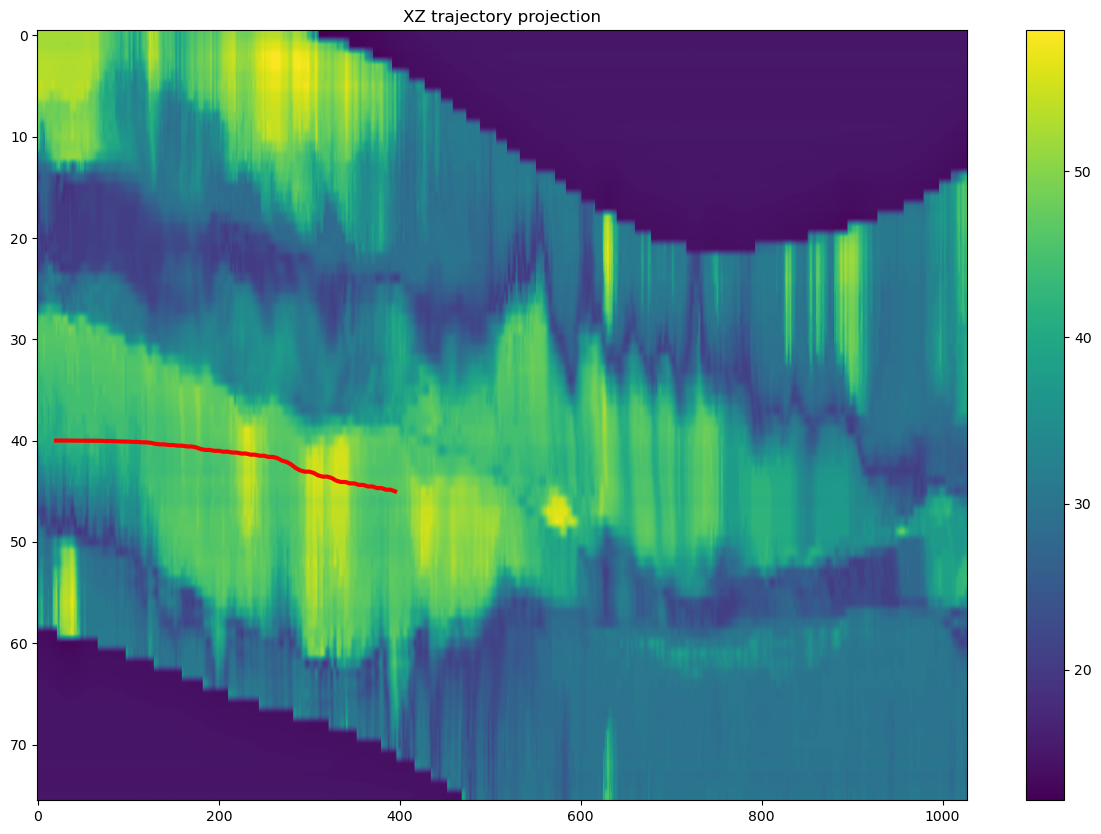

In [215]:
fig, ax = plt.subplots(1,1, figsize = (15,10))
property_along_y_arr = np.array(property_along_y)
property_along_x_arr = np.array(property_along_x)
property_along_z_arr = np.array(property_along_z)
ax.plot(z_t.T,x_t.T, color = 'r', linewidth = 3 )
ax.set_title('XZ trajectory projection')

#ax.imshow(property_along_z_arr.T[::-1])

p_map = ax.imshow(property_along_y_arr, aspect='auto')
plt.colorbar(p_map)

In [107]:
traj_x_2 =  [traj_x[0],  traj_x[-1]]
traj_y_2 =  [traj_y[0], traj_y[-1]]
traj_z_2 =  [traj_z[0],traj_z[50], traj_z[-1]]

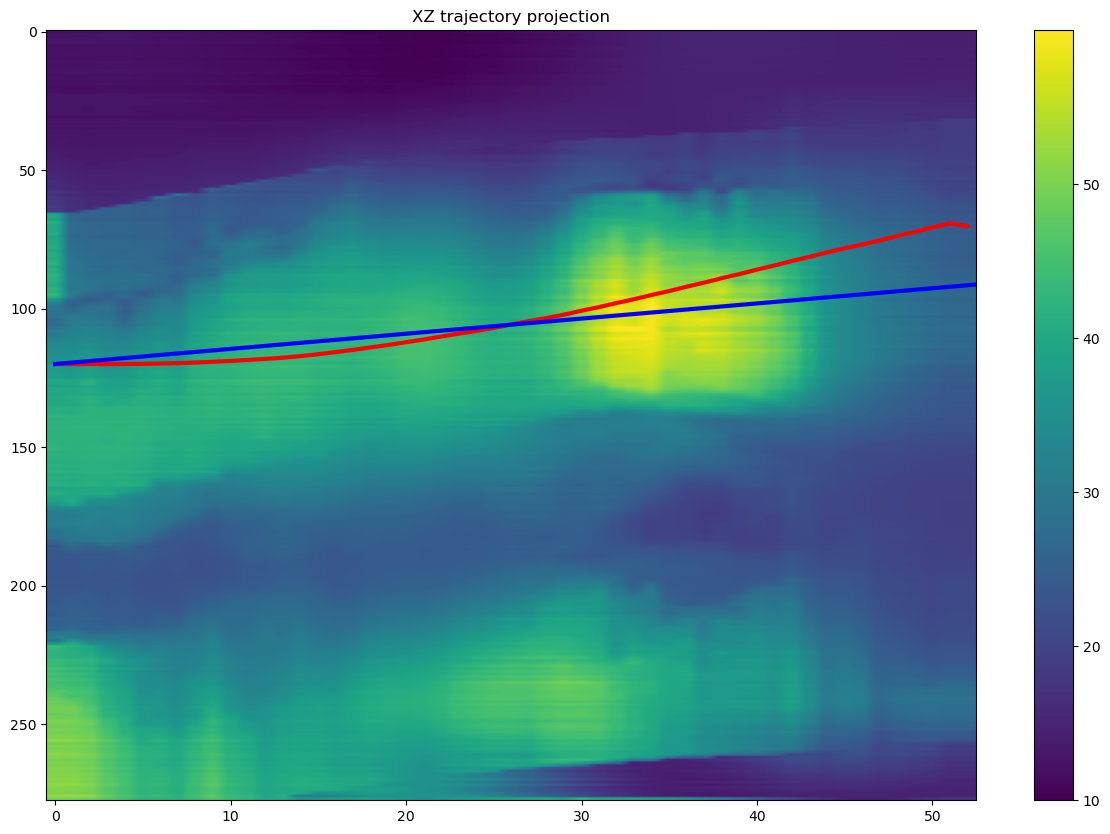

In [110]:

x = []
z = []
y = []
property_along_y = []
property_along_x = []
property_along_z = []
for i in range(0,len(traj_x)):
    x.append(traj_x[i])
    z.append(traj_z[i])
    y.append(traj_y[i])
    property_along_y.append(volume_cut[round(traj_x[i]),:,round(traj_z[i])].T)
    property_along_x.append(volume_cut[:,round(traj_y[i]),round(traj_z[i])].T)
    property_along_z.append(volume_cut[round(traj_x[i]),round(traj_y[i]),:].T)


x_t = np.array(x)
z_t = np.array(z)
y_t = np.array(y)
fig, ax = plt.subplots(1,1, figsize = (15,10))
property_along_y_arr = np.array(property_along_y)
property_along_x_arr = np.array(property_along_x)
property_along_z_arr = np.array(property_along_z)
ax.plot(y_t, color = 'r', linewidth = 3 )
ax.set_title('XZ trajectory projection')
ax.plot([0,91],traj_y_2, color = 'b', linewidth = 3 )

#ax.imshow(property_along_z_arr.T[::-1])

p_map = ax.imshow(property_along_y_arr.T[::-1], aspect='auto')
plt.colorbar(p_map)

# Polar coordinates greedy algorithm

In [104]:
plot(traj_x,traj_y,traj_z)